## **Brain Tumor Classification**

Transfer Learning EfficientNetB1 model

## **1. Setup**

### **1.1 Imports**

In [1]:
# Import necessary libraries
import pathlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### **1.2 Constants**

In [2]:
BATCH_SIZE = 32
IMG_SIZE = 240
CLASS_MODE_SPARSE = 'sparse'
INTERPOLATION_BILINEAR = 'bilinear'
SEED = 1234

## **2. Load dataset**

### **2.1 Clone data on Google Colab**

In [3]:
# Download dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 17.82 MiB/s, done.


In [4]:
!ls /content/Brain-Tumor-Classification-DataSet/

Testing  Training


In [5]:
# Train set and test set data directory
train_data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Training')
test_data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Testing')

### **2.2 Load data and perform image augmentation**

#### **2.2.1. Create image data generators**

In [6]:
# Data generator without image augmentation
datagen_normal = ImageDataGenerator()

# Data generator with image augmentation
datagen_aug = ImageDataGenerator(rotation_range=10,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='constant',
                                 validation_split=0.2
)

#### **2.2.2 Load data**

In [7]:
# Training set
train_data = datagen_aug.flow_from_directory(train_data_dir, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             batch_size=BATCH_SIZE, 
                                             class_mode='sparse',
                                             subset='training')

Found 2297 images belonging to 4 classes.


In [8]:
# Validation set
val_data = datagen_aug.flow_from_directory(train_data_dir, 
                                           target_size=(IMG_SIZE, IMG_SIZE), 
                                           batch_size=BATCH_SIZE, 
                                           class_mode='sparse',
                                           subset='validation')

Found 573 images belonging to 4 classes.


In [9]:
# Testing set
test_data = datagen_normal.flow_from_directory(test_data_dir, 
                                               target_size=(IMG_SIZE, IMG_SIZE), 
                                               class_mode='sparse')

Found 394 images belonging to 4 classes.


In [10]:
num_classes = 4

In [11]:
train_data.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

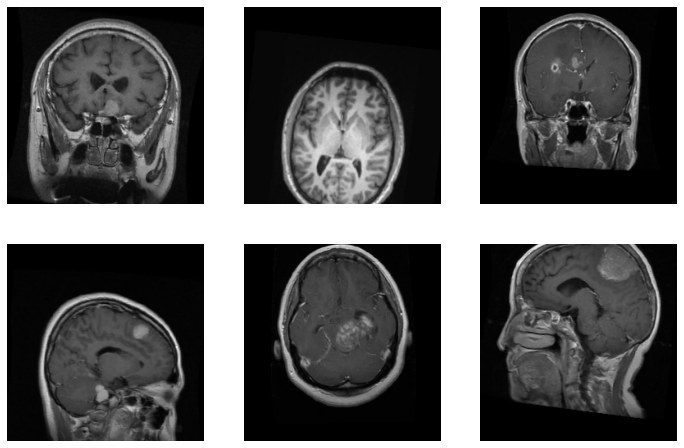

In [12]:
# View 6 samples of the augmented images
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sample = array_to_img(sample_x[i])
    plt.axis('off')
    plt.grid(False)
    plt.imshow(sample)
plt.show()

#### **2.2.3 Compute the class weight**

In [13]:
# Get the Training set labels
train_labels = np.array([])

for batch in range(len(train_data)):
    x, y = train_data[batch]
    train_labels = np.concatenate([train_labels, y])

In [14]:
# Compute class weight
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced', 
                                                                      classes=np.asarray(range(4)), 
                                                                      y=train_labels)))
print(class_weights_dict)

{0: 0.8687594553706506, 1: 0.8727203647416414, 2: 1.817246835443038, 3: 0.8674471299093656}


## **3. Build our CNN model based on EfficientNetB1 model**

Use EfficientNet as a feature extractor in our transfer learning workflow.

In [15]:
base_model = EfficientNetB1(weights='imagenet',  # Load weigths pre-trained on ImageNet
                            include_top=False,   # Do not include the ImageNetclassifer at the top
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model pretrained weights
base_model.trainable = False

27033600/27018416 [==============================] - 0s 0us/step


In [16]:
# Rebuild model top
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# The base model contains batchnorm layers. 
# By setting training=False, we keep the batchnorm layers in inference mode
# when we unfreeze the base model for fine-tuning.
x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Regularize with dropout

outputs = Dense(num_classes, activation='softmax', name='predict')(x)

model = Model(inputs, outputs)

In [17]:
base_learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
predict (Dense)              (None, 4)                 5124      
Total params: 6,580,363
Trainable params: 5,124
Non-trainable params: 6,575,239
_________________________________________________________________


In [19]:
num_train_epochs = 10
train_history = model.fit(train_data, 
                          epochs=num_train_epochs, 
                          validation_data=val_data, 
                          class_weight = class_weights_dict,
                          verbose=1,
                          callbacks=earlystop)

Epoch 1/10
72/72 [==============================] - 70s 662ms/step - loss: 1.0483 - accuracy: 0.5568 - val_loss: 0.9033 - val_accuracy: 0.6091
Epoch 2/10
72/72 [==============================] - 46s 645ms/step - loss: 0.6883 - accuracy: 0.7357 - val_loss: 0.7538 - val_accuracy: 0.6789
Epoch 3/10
72/72 [==============================] - 49s 679ms/step - loss: 0.5912 - accuracy: 0.7710 - val_loss: 0.6971 - val_accuracy: 0.6911
Epoch 4/10
72/72 [==============================] - 47s 659ms/step - loss: 0.5297 - accuracy: 0.8032 - val_loss: 0.6626 - val_accuracy: 0.7312
Epoch 5/10
72/72 [==============================] - 49s 686ms/step - loss: 0.4855 - accuracy: 0.8198 - val_loss: 0.6267 - val_accuracy: 0.7365
Epoch 6/10
72/72 [==============================] - 49s 683ms/step - loss: 0.4780 - accuracy: 0.8124 - val_loss: 0.6108 - val_accuracy: 0.7487
Epoch 7/10
72/72 [==============================] - 47s 655ms/step - loss: 0.4481 - accuracy: 0.8315 - val_loss: 0.5831 - val_accuracy: 0.7522

The train accuracy is 85.85% and the validation accuracy is 76.61%.

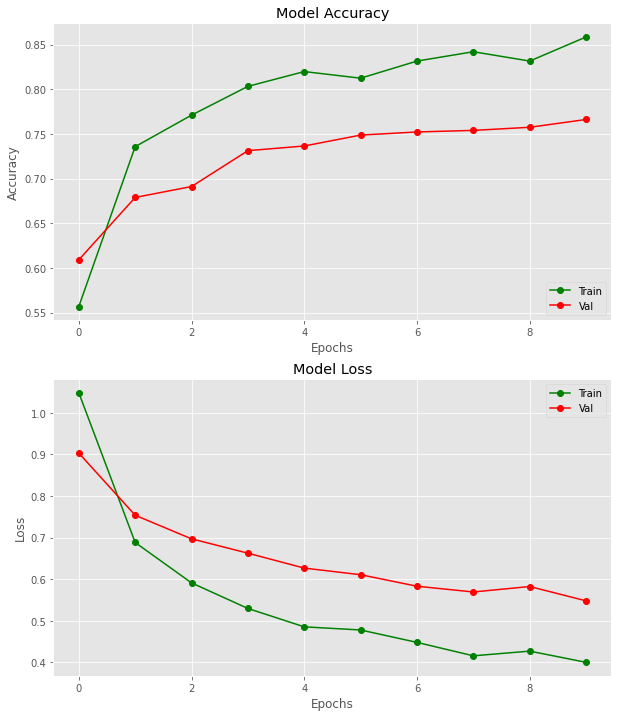

In [20]:
# Plot the training curves
train_acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(10,12))
#epochs = range(1,11)

plt.subplot(2, 1, 1)
plt.plot(train_acc, 'go-', label='Training Accuracy')
plt.plot(val_acc, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(train_loss, 'go-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


Evaluate model performance on the test dataset:

In [21]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 2s - loss: 1.4048 - accuracy: 0.5990
Test accuracy is 59.90%


## **4. Fine-tune the base EfficientNetB1 model**

In [22]:
# Unfreeze the base model and train the entire model end-to-end
# The base model is still running in inference mode, 
# since we passed base_model.trainable=False when calling it when we built the model.
# The batch normalization layers inside will not update their batch statistics.
base_model.trainable = True

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
predict (Dense)              (None, 4)                 5124      
Total params: 6,580,363
Trainable params: 6,518,308
Non-trainable params: 62,055
_________________________________________________________________


We see that the number of trainable params increased substantially after unfreezing the base model.

In [24]:
fine_tune_learning_rate = 1e-5
model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
num_tune_epochs = 50
total_epochs = num_train_epochs + num_tune_epochs
tuned_history = model.fit(train_data, 
                          epochs=total_epochs,
                          initial_epoch=train_history.epoch[-1] ,
                          validation_data=val_data, 
                          class_weight = class_weights_dict,
                          verbose=1,
                          callbacks=earlystop)

Epoch 10/60
72/72 [==============================] - 75s 832ms/step - loss: 0.3741 - accuracy: 0.8533 - val_loss: 0.4863 - val_accuracy: 0.7976
Epoch 11/60
72/72 [==============================] - 58s 804ms/step - loss: 0.3174 - accuracy: 0.8724 - val_loss: 0.4497 - val_accuracy: 0.8290
Epoch 12/60
72/72 [==============================] - 58s 803ms/step - loss: 0.2599 - accuracy: 0.8907 - val_loss: 0.4115 - val_accuracy: 0.8412
Epoch 13/60
72/72 [==============================] - 54s 744ms/step - loss: 0.2315 - accuracy: 0.9116 - val_loss: 0.3831 - val_accuracy: 0.8534
Epoch 14/60
72/72 [==============================] - 49s 673ms/step - loss: 0.1981 - accuracy: 0.9260 - val_loss: 0.3573 - val_accuracy: 0.8569
Epoch 15/60
72/72 [==============================] - 48s 659ms/step - loss: 0.1743 - accuracy: 0.9356 - val_loss: 0.3567 - val_accuracy: 0.8621
Epoch 16/60
72/72 [==============================] - 47s 657ms/step - loss: 0.1462 - accuracy: 0.9438 - val_loss: 0.3154 - val_accuracy:

In [26]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 2s - loss: 1.6774 - accuracy: 0.7766
Test accuracy is 77.66%


## **5. Model Evaluation**

### **5.1 Training and validation accuracy and loss**

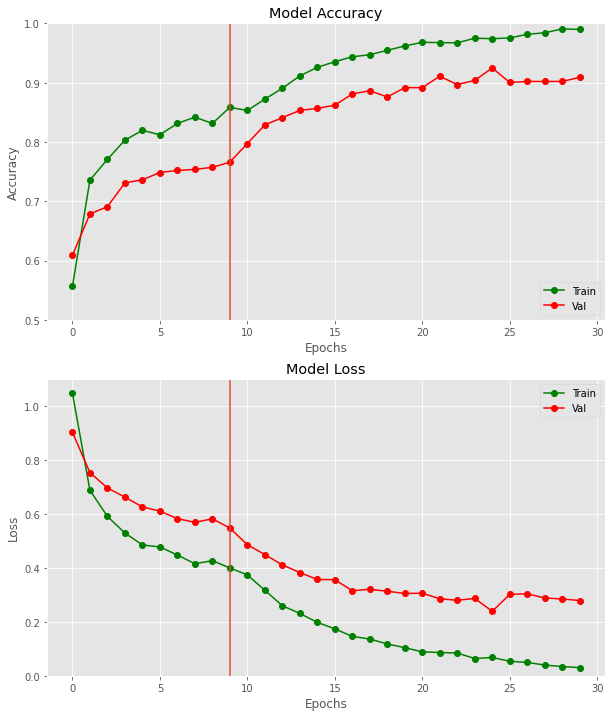

In [27]:
# Plot the training curves
train_acc += tuned_history.history['accuracy']
val_acc += tuned_history.history['val_accuracy']

train_loss += tuned_history.history['loss']
val_loss += tuned_history.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(10,12))

plt.subplot(2, 1, 1)
plt.plot(train_acc, 'go-', label='Training Accuracy')
plt.plot(val_acc, 'ro-', label='Validation Accuracy')
plt.ylim([0.5, 1.0])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(train_loss, 'go-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.ylim([0, 1.1])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### **5.2 Confusion matrix and classification report**

In [28]:
# Get the labels
predictions = np.array([])
true_labels = np.array([])

for batch in range(len(test_data)):
    x, y = test_data[batch]
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])

# Look at the first 20 predictions and labels
print('predictions = ', predictions[:20])
print('True labels = ', true_labels[:20])

predictions =  [1. 1. 2. 3. 1. 3. 1. 2. 3. 2. 0. 0. 3. 1. 3. 2. 3. 3. 1. 3.]
True labels =  [0. 1. 2. 2. 1. 3. 0. 2. 3. 2. 0. 0. 3. 1. 3. 2. 3. 3. 0. 3.]


Sample images and their corresponding true and predicted labels

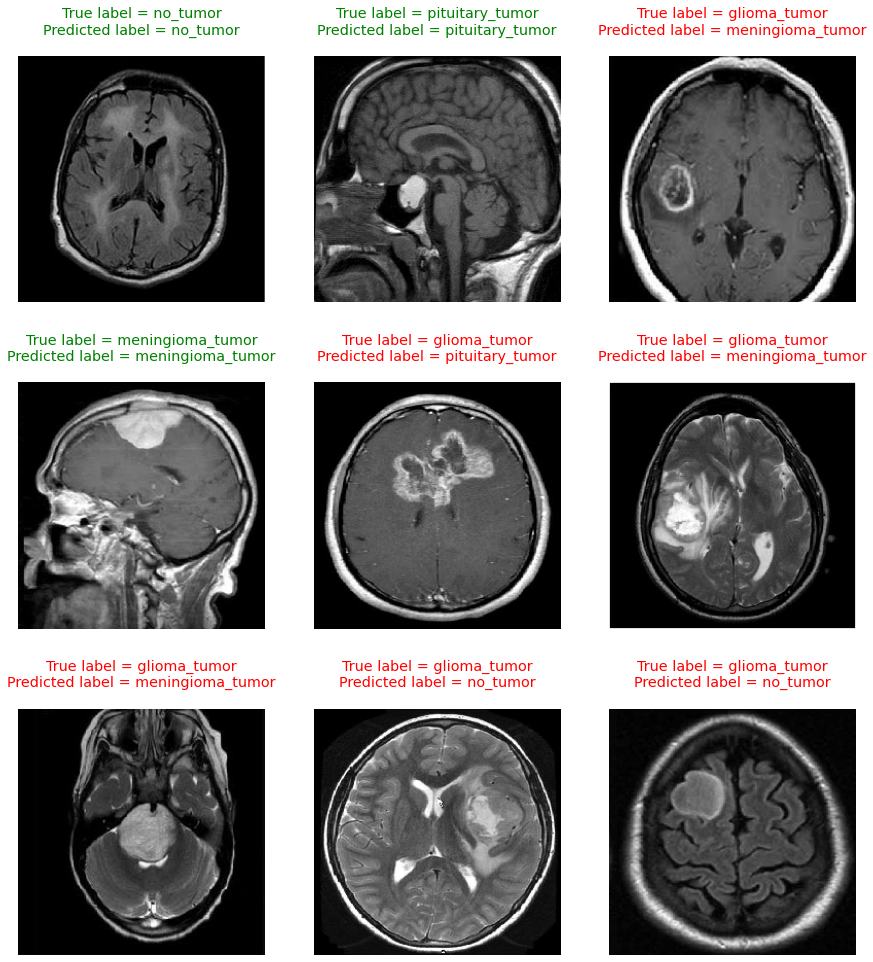

In [29]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

sample_img, sample_true_labels = next(test_data)
sample_predictions = np.argmax(model.predict(sample_img), axis=-1)

plt.figure(figsize=(15,17))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.grid(False)

    sample = array_to_img(sample_img[i])
    plt.imshow(sample)
    
    true_class_name = class_names[int(sample_true_labels[i])]
    predicted_class_name = class_names[sample_predictions[i]]

    title_color = 'red'
    if predicted_class_name == true_class_name:
        title_color = 'green'

    plt.title("True label = {}\nPredicted label = {}\n".format(true_class_name, predicted_class_name), color=title_color)
plt.show()

In [30]:
# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)
print('Confusion matrix:', cm)

Confusion matrix: tf.Tensor(
[[ 24  53  17   6]
 [  0 113   1   1]
 [  3   1  98   3]
 [  0   0   3  71]], shape=(4, 4), dtype=int32)


In [31]:
# Classification Report
print('Classification Report:\n')
print(classification_report(true_labels, predictions, target_names=test_data.class_indices.keys()))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.24      0.38       100
meningioma_tumor       0.68      0.98      0.80       115
        no_tumor       0.82      0.93      0.87       105
 pituitary_tumor       0.88      0.96      0.92        74

        accuracy                           0.78       394
       macro avg       0.82      0.78      0.74       394
    weighted avg       0.81      0.78      0.74       394



### **5.3 Save model performance**

In [32]:
report = classification_report(true_labels, predictions, target_names=test_data.class_indices.keys(), output_dict=True)
performance = {'Model': [],
               'Train accuracy': [],
               'Train loss': [],
               'Test accuracy': [],
               'Test loss': [],
               'Glioma Precision': [],
               'Glioma Recall': [],
               'Meningioma Precision': [],
               'Meningioma Recall': [],
               'No Tumor Precision': [],
               'No Tumor Recall': [],
               'Pituitary Precision': [],
               'Pituitary Recall': []
               }

performance['Model'].append('EffNetB1 model')
performance['Train accuracy'].append(train_acc[-1])
performance['Train loss'].append(train_loss[-1])
performance['Test accuracy'].append(test_accuracy)
performance['Test loss'].append(test_loss)
performance['Glioma Precision'].append(report['glioma_tumor']['precision'])
performance['Glioma Recall'].append(report['glioma_tumor']['recall'])
performance['Meningioma Precision'].append(report['meningioma_tumor']['precision'])
performance['Meningioma Recall'].append(report['meningioma_tumor']['recall'])
performance['No Tumor Precision'].append(report['no_tumor']['precision'])
performance['No Tumor Recall'].append(report['no_tumor']['recall'])
performance['Pituitary Precision'].append(report['pituitary_tumor']['precision'])
performance['Pituitary Recall'].append(report['pituitary_tumor']['recall'])

df_performance = pd.DataFrame(performance)
df_performance.to_csv('EfficientNetB1_performance.csv', index=False)